In [37]:
import math
import random
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns

from keras.models import Sequential
from keras import layers
from keras  import optimizers
from keras import losses

matplotlib.style.use('ggplot')

In [23]:
env = gym.make('CartPole-v0')

STATE_COUNT  = env.observation_space.shape[0]
ACTION_COUNT = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [24]:
# Brain

BATCH_SIZE_BASELINE = 50  # calculate average reward over these many episodes
H = 64                   # hidden layer size
LEARNING_RATE=0.001

class Brain:
    def __init__(self):
        self.params = {}
        self.lr = LEARNING_RATE
        self.model= self._create()
        # self.model.load_weights("cartpole-basic.h5")
        
    def _create(self):
        
        model = Sequential()
        model.add(layers.Dense(units=64, activation='relu', input_dim=STATE_COUNT))
        model.add(layers.Dense(units=ACTION_COUNT, activation='linear'))

       
        W1=model.get_weights()[0]
        b1=model.get_weights()[1]
        W2=model.get_weights()[2]
        b2=model.get_weights()[3]
        
        self.params = dict(W1=W1, b1=b1, W2=W2, b2=b2)            
        
       
        optimizer = optimizers.adam(lr=self.lr)
        model.compile(loss='mse', optimizer=optimizer)
        

        return model

    def train(self, x, y, epoch=1, verbose=0):
        self.model.fit(x, y, batch_size=64,epochs=epoch, verbose=verbose)
        

    def predict(self, s):
        return self.model.predict(s,batch_size=64)


In [25]:
# Memory

class Memory:   # stored as ( s, a, r, s_ )
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add_sample(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def get_sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

In [26]:
# Agent Policy 
  
MAX_EPSILON = 1
MIN_EPSILON = 0.01 # stay a bit curious even when getting old

class Policy:

    epsilon = MAX_EPSILON
    
    def __init__(self):
        pass
    
    def get_action(self,s,brain):
        
        if random.random() < self.epsilon:
            return random.randint(0, ACTION_COUNT-1)
        else:
            s=np.reshape(s,newshape=(1,4))
            return np.argmax(brain.predict(s)) 
    
    def decay_epsilon(self,steps):
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
        return self.epsilon
        

In [27]:
MEMORY_CAPACITY = 100000
BATCH_SIZE = 64

GAMMA = 0.99 # discount factor
LAMBDA = 0.0001    # speed of decay



class Agent:
    steps = 0

    def __init__(self):
        self.brain = Brain()
        self.memory = Memory(MEMORY_CAPACITY)
        self.policy = Policy()
        
    def act(self, s):
        action=self.policy.get_action(s,self.brain)
        return action

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add_sample(sample)    
        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.policy.decay_epsilon(self.steps)

    def replay(self):    
        batch = self.memory.get_sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = np.zeros(STATE_COUNT)

        
        states = np.array([ o[0] for o in batch ], dtype=np.float32)
        states_ = np.array([(no_state if o[3] is None else o[3]) for o in batch ], dtype=np.float32)

        p = self.brain.predict(states)
        p_ = self.brain.predict(states_)

        x = np.zeros((batchLen, STATE_COUNT)).astype(np.float32)
        y = np.zeros((batchLen, ACTION_COUNT)).astype(np.float32)
        
        for i in range(batchLen):
            s, a, r, s_ = batch[i]
            
            t = p[i]
            if s_ is None:
                t[a] = r
                
            else:
                t[a] = r + GAMMA * np.amax(p_[i])      # calculate the target: r+ Gamma*max Q(s',a')

            x[i] = s
            y[i] = t

        self.brain.train(x, y)

In [28]:
# Helper Functions

def plot_weights(weights, figsize=(7,5)):
    '''Heat map of weights to see which neurons play which role'''
    sns.set(style="white")
    f, ax = plt.subplots(len(weights), figsize=figsize)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    for i, data in enumerate(weights):
        axi = ax if len(weights)==1 else ax[i]
        if isinstance(data, tuple): 
            w, title = data
            axi.set_title(title)
        else:
            w = np.asarray(data)
        plot=sns.heatmap(w, cmap=cmap, square=True, center=True, #annot=True,
                    linewidths=.5, cbar_kws={"shrink": .25}, ax=axi)
        plot.get_figure().savefig("Weights.png")

In [29]:
def run(agent):
    s = env.reset()
    R = 0 
    episode_length_counter=1
  

    while True:            
        #env.render()


        a = agent.act(s.astype(np.float32))
        #print(a)

        s_, r, done, info = env.step(a)
        
        episode_length_counter+=1

        if done: # terminal state
            s_ = None

        agent.observe((s, a, r, s_))
        agent.replay()            

        s = s_
        R += r
        
        if done:
            return R,episode_length_counter

Episode:  100
Rewards:  59.0
Max reward so far:  106.0
Mean Reward 30.504950495049506
Episode:  200
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 76.2139303482587
Episode:  300
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 117.33887043189368
Episode:  400
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 137.8129675810474
Episode:  500
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 150.07385229540918
Episode:  600
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 158.26289517470883
Episode:  700
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 161.86305278174038
Episode:  800
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 161.6629213483146
Episode:  900
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 161.49167591564927
Episode:  1000
Rewards:  200.0
Max reward so far:  200.0
Mean Reward 164.57442557442556


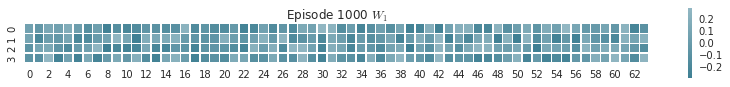

In [30]:
agent = Agent()
episode_number = 0
reward_sum = 0
solved=1000
number_of_episodes=1000
G=[]
mean_G_all=[]
episodes_length=np.zeros((number_of_episodes,1))

while episode_number<number_of_episodes:
    episode_states=[]
    episode_rewards=[]
    episode_actions=[]
    episode_length_counter=1
    
    R,episode_length_counter= run(agent)
    
    G.append(R)
    reward_sum=sum(G)
    
    episodes_length[episode_number]=episode_length_counter

    
    episode_number += 1

    if episode_number%100==0:
                
        print("==========================================")
        print("Episode: ", episode_number)
        print("Rewards: ", R)
        print("Max reward so far: ", max(G))
        # Mean reward
        mean_G = np.divide(sum(G), episode_number+1)
        mean_G_all.append(mean_G)
        print("Mean Reward", mean_G)
        
        
        if episode_number%solved==0:
            plot_weights([(agent.brain.params['W1'], 'Episode %i $W_1$'%episode_number)], figsize=(14,5))
        if mean_G > solved:
            print('Task solved in %d episodes' % episode_number)
            plot_weights([(agent.brain.params['W1'], 'Episode %i $W_1$'%episode_number)], figsize=(14,5))            
            break
        reward_sum = 0
        
agent.brain.model.save('Models/dqn.mod')

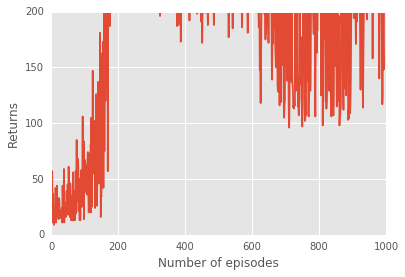

In [38]:
plt.plot(G)
plt.ylabel('Returns')
plt.xlabel('Number of episodes')

plt.savefig("plots/DQN_epVsG")

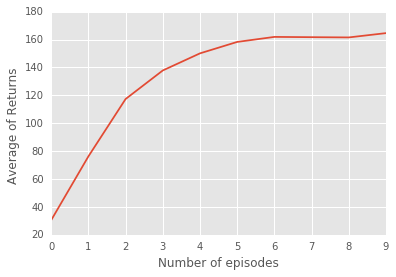

In [39]:
plt.plot(mean_G_all)
plt.ylabel('Average of Returns ')
plt.xlabel('Number of episodes')
plt.savefig("plots/DQN_epVsAVG")

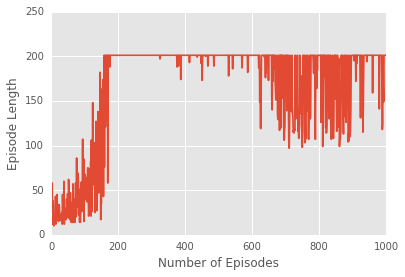

In [40]:
plt.plot(episodes_length)
plt.ylabel('Episode Length')
plt.xlabel('Number of Episodes')
plt.savefig("plots/DQN_epVsepLength")

In [34]:
variance=np.std(G)
print(variance)

58.93977331988986
